# Atoti Value-at-Risk benchmark

This notebook is a benchmark template used to expose Atoti performances over ClickHouse by reproducing a benchmark detailed in a [blog post by Altinity on calculating Value-at-Risk (VaR)](https://altinity.com/blog/clickhouse-vs-redshift-performance-for-fintech-risk-management). Check out the [full article](https://www.activeviam.com/blog/atoti-for-risk-management-aggregation-comparison-with-the-clickhouse-benchmark/)

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti" /></a></div>

In [1]:
import time
import atoti
import pandas as pd

In [2]:
session = atoti.Session(
    name="RiskBenchmark", java_options=["-XX:MaxDirectMemorySize=12G"]
)

In [3]:
# Load risk dataset
dataset = session.read_parquet(
    "dataset.parquet",
    partitioning="hash32(str0)",
    default_values={
        "int10": 0, 
        "int11": 0, 
        "int12": 0, 
        "int13": 0,
        "dttime10": 0,
        "dttime11": 0,
        "dttime12": 0,
        "dttime13": 0,
    },
)

In [4]:

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 500)

In [25]:
dataset.head()

,index,int0,int1,int2,int3,int4,int5,int6,int7,int8,int9,int10,int11,int12,int13,int14,int15,int16,int17,int18,int19,int20,int21,int22,int23,int24,int25,int26,int27,int28,int29,int30,int31,int32,int33,dttime0,dttime1,dttime2,dttime3,dttime4,dttime5,dttime6,dttime7,dttime8,dttime9,dttime10,dttime11,dttime12,dttime13,dttime14,dttime15,dttime16,dttime17,dttime18,dttime19,dttime20,dttime21,dttime22,dttime23,dttime24,dttime25,dttime26,dttime27,dttime28,dttime29,dttime30,dttime31,dttime32,str0,str1,str2,str3,str4,str5,str6,str7,str8,str9,str10,str11,str12,str13,str14,str15,str16,str17,str18,str19,str20,str21,str22,str23,str24,str25,str26,str27,str28,str29,str30,str31,str32,arrFloat,partition
0,0,-689256,-458623,-625436,-263674,-458623,-625436,-551758,-263674,219160,-395526,-689256,-395526,-625436,219160,-625436,-625436,-50266,-625436,-264169,-50266,-625436,-160948,-160948,-50266,-50266,-160948,-625436,-458623,-264169,-160948,-625436,-395526,-50266,-50266,1638867543000000000,1781777447000000000,1638867543000000000,1638867543000000000,1819862349000000000,1781777447000000000,1807013976000000000,1890128456000000000,1807013976000000000,1890128456000000000,2128020817000000000,1890128456000000000,1781777447000000000,2128020817000000000,1888982281000000000,2268946597000000000,1888982281000000000,1819862349000000000,1890128456000000000,2268946597000000000,1888982281000000000,1638867543000000000,1807013976000000000,1890128456000000000,1819862349000000000,1807013976000000000,1807013976000000000,1890128456000000000,2502509230000000000,1890128456000000000,1888982281000000000,1807013976000000000,1807013976000000000,YQOaNFvp,RvEJgwBu,CffuGFgtJsThJv,YQOaNFvp,RvEJgwBu,jtgUe,NOnJECHqdZJafUzT,fMZyuKpslm,RvEJgwBu,NOnJECHqdZJafUzT,iWgNZqITZM,iWgNZqITZM,fMZyuKpslm,UuTemKopZjZI,fMZyuKpslm,YQOaNFvp,NOnJECHqdZJafUzT,iWgNZqITZM,CffuGFgtJsThJv,yWAcqGFzYtEwLnGis,UuTemKopZjZI,iWgNZqITZM,YQOaNFvp,jtgUe,CffuGFgtJsThJv,YQOaNFvp,UuTemKopZjZI,YQOaNFvp,RvEJgwBu,CffuGFgtJsThJv,iWgNZqITZM,RvEJgwBu,jtgUe,"[458115.03, 240582.39, 297708.62, 38402.438, 9...",0
1,7,-263674,-160948,219160,219160,219160,-263674,-50266,-263674,-551758,-551758,-395526,-264169,-625436,-689256,-160948,-625436,-689256,-458623,-689256,-458623,-50266,-625436,-551758,-551758,-395526,-689256,219160,219160,-689256,-50266,-264169,-263674,-50266,-625436,1638867543000000000,1807013976000000000,1819862349000000000,1819862349000000000,1884470297000000000,1890128456000000000,2268946597000000000,1807013976000000000,2268946597000000000,1884470297000000000,2502509230000000000,1888982281000000000,2502509230000000000,2268946597000000000,1807013976000000000,1888982281000000000,1638867543000000000,2502509230000000000,2502509230000000000,1807013976000000000,1819862349000000000,1638867543000000000,1781777447000000000,1638867543000000000,1781777447000000000,1781777447000000000,1890128456000000000,1807013976000000000,1638867543000000000,1888982281000000000,2268946597000000000,2128020817000000000,1890128456000000000,YQOaNFvp,RvEJgwBu,UuTemKopZjZI,fMZyuKpslm,jtgUe,InZMJLsC,InZMJLsC,iWgNZqITZM,RvEJgwBu,iWgNZqITZM,iWgNZqITZM,fMZyuKpslm,yWAcqGFzYtEwLnGis,fMZyuKpslm,UuTemKopZjZI,yWAcqGFzYtEwLnGis,YQOaNFvp,fMZyuKpslm,RvEJgwBu,fMZyuKpslm,NOnJECHqdZJafUzT,NOnJECHqdZJafUzT,InZMJLsC,iWgNZqITZM,iWgNZqITZM,yWAcqGFzYtEwLnGis,InZMJLsC,NOnJECHqdZJafUzT,InZMJLsC,InZMJLsC,yWAcqGFzYtEwLnGis,fMZyuKpslm,jtgUe,"[393452.28, 847860.94, 897599.1, 369935.4, 471...",0
2,17,-50266,-458623,-689256,-458623,-263674,219160,-625436,-551758,219160,-263674,219160,-625436,-263674,-263674,-160948,-50266,-264169,219160,219160,-458623,219160,-689256,-395526,-458623,-263674,-689256,-263674,-160948,-458623,-458623,-395526,-625436,-689256,-551758,1884470297000000000,1884470297000000000,1888982281000000000,1890128456000000000,1781777447000000000,1781777447000000000,2502509230000000000,1781777447000000000,1638867543000000000,1807013976000000000,1638867543000000000,1890128456000000000,1638867543000000000,1781777447000000000,2502509230000000000,1807013976000000000

In [6]:
cube = session.create_cube(dataset)

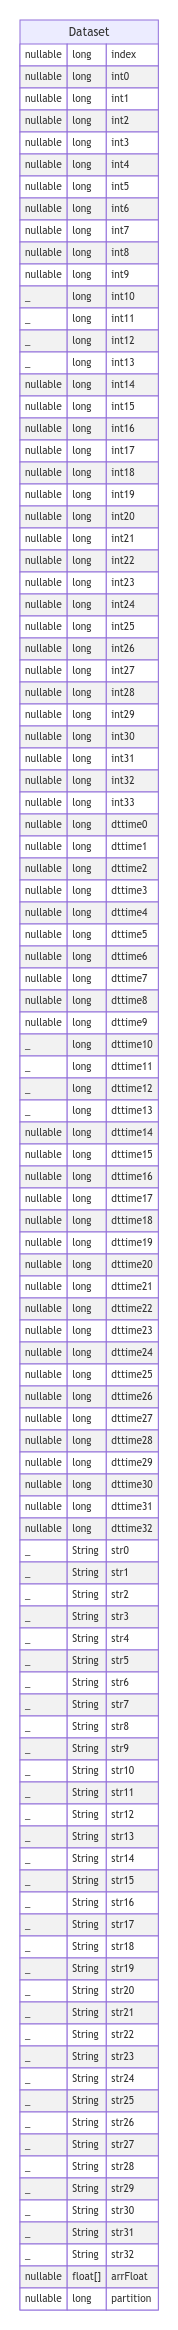

In [7]:
session.tables.schema

In [8]:
# Disable the aggregate cache
cube.aggregates_cache.capacity = -1

In [9]:
# Define vector aggregation and value at risk
h, m, l = cube.hierarchies, cube.measures, cube.levels

m["PnlVector"] = atoti.agg.sum(dataset["arrFloat"])
m["ValueAtRisk"] = atoti.array.quantile(m["PnlVector"], q=0.95)

In [10]:
# Create a hierarchy to access vector elements
cube.create_parameter_hierarchy_from_members("Scenarios", list(range(0, 1000)))
m["PnL at index"] = m["PnlVector"][l["Scenarios"]]

Creating hierarchies for numerical columns required for querying.

In [11]:
h["int10"] = [dataset["int10"]]
h["int11"] = [dataset["int11"]]
h["int12"] = [dataset["int12"]]
h["int13"] = [dataset["int13"]]
h["dttime10"] = [dataset["dttime10"]]
h["dttime11"] = [dataset["dttime11"]]
h["dttime12"] = [dataset["dttime12"]]
h["dttime13"] = [dataset["dttime13"]]

In [12]:
session.link

http://localhost:50120

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

In [13]:
# Number of facts in the cube
cube.query(m["contributors.COUNT"])

,contributors.COUNT
0,"404,800"


### Query Benchmark

In [14]:
def Q1():
    return cube.query(m["ValueAtRisk"], levels=[l["str0"]], mode="raw")


def Q2():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["int10"],
            l["int11"],
            l["dttime10"],
            l["dttime11"],
        ],
        mode="raw",
    )


def Q3():
    return cube.query(
        m["ValueAtRisk"],
        levels=[
            l["str0"],
            l["str1"],
            l["str2"],
            l["str3"],
            l["int10"],
            l["int11"],
            l["int12"],
            l["int13"],
            l["dttime10"],
            l["dttime11"],
            l["dttime12"],
            l["dttime13"],
        ],
        mode="raw",
    )


def Q4():
    return cube.query(
        m["PnL at index"],
        levels=[l["str0"], l["Scenarios"]],
        filter=(l["str1"] == "KzORBHFRuFFOQm"),
        mode="raw",
    )


# Iterations
iterations = 10


def benchmark(name, task):
    # Warmup
    for w in range(10):
        task()

    start = time.time()
    for i in range(iterations):
        task()
    elapsed = time.time() - start

    print(f"{name} average query time {round(1000*elapsed/iterations)} ms")

In [15]:
benchmark("Q1", Q1)

Q1 average query time 36 ms


In [16]:
benchmark("Q2", Q2)

Q2 average query time 48 ms


In [17]:
benchmark("Q3", Q3)

Q3 average query time 48 ms


In [18]:
benchmark("Q4", Q4)

Q4 average query time 12 ms


### Launch queries manually

In [19]:
%%time
Q1()

CPU times: user 2.82 ms, sys: 1.47 ms, total: 4.29 ms
Wall time: 37.2 ms


,str0,ValueAtRisk
0,YQOaNFvp,23834421248.0
1,jtgUe,23578234880.0
2,fMZyuKpslm,40247771136.0
3,NOnJECHqdZJafUzT,19098873856.0
4,yWAcqGFzYtEwLnGis,23704393728.0
5,RvEJgwBu,41939386368.0
6,InZMJLsC,23740125184.0
7,iWgNZqITZM,23992991744.0
8,UuTemKopZjZI,21767061504.0
9,CffuGFgtJsThJv,19413624832.0


In [20]:
%%time
Q2()

CPU times: user 4.86 ms, sys: 2.88 ms, total: 7.73 ms
Wall time: 54.4 ms


,str0,str1,int10,int11,dttime10,dttime11,ValueAtRisk
0,YQOaNFvp,RvEJgwBu,-689256,-395526,2128020817000000000,1890128456000000000,3767694848.0
1,YQOaNFvp,RvEJgwBu,-395526,-264169,2502509230000000000,1888982281000000000,3834327296.0
2,YQOaNFvp,CffuGFgtJsThJv,219160,-625436,1638867543000000000,1890128456000000000,3804643072.0
3,YQOaNFvp,fMZyuKpslm,-551758,-689256,1884470297000000000,1781777447000000000,3775642880.0
4,YQOaNFvp,fMZyuKpslm,-458623,-689256,2268946597000000000,1638867543000000000,3816820480.0
5,YQOaNFvp,iWgNZqITZM,-264169,-395526,1890128456000000000,1781777447000000000,3849314816.0
6,YQOaNFvp,UuTemKopZjZI,-50266,-458623,1781777447000000000,2128020817000000000,3779459328.0
7,YQOaNFvp,jtgUe,-263674,-395526,1638867543000000000,1807013976000000000,3843651584.0
8,YQOaNFvp,RvEJgwBu,-625436,-395526,1888982281000000000,2502509230000000000,3878607616.0
9,jtgUe,CffuGFgtJsThJv,-625436,-625436,1807013976000000000,1888982281000000000,3844956672.0


In [21]:
%%time
Q3()

CPU times: user 6.72 ms, sys: 4.35 ms, total: 11.1 ms
Wall time: 55.9 ms


,str0,str1,str2,str3,int10,int11,int12,int13,dttime10,dttime11,dttime12,dttime13,ValueAtRisk
0,YQOaNFvp,RvEJgwBu,CffuGFgtJsThJv,YQOaNFvp,-689256,-395526,-625436,219160,2128020817000000000,1890128456000000000,1781777447000000000,2128020817000000000,3767694848.0
1,YQOaNFvp,RvEJgwBu,UuTemKopZjZI,fMZyuKpslm,-395526,-264169,-625436,-689256,2502509230000000000,1888982281000000000,2502509230000000000,2268946597000000000,3834327296.0
2,YQOaNFvp,CffuGFgtJsThJv,iWgNZqITZM,RvEJgwBu,219160,-625436,-263674,-263674,1638867543000000000,1890128456000000000,1638867543000000000,1781777447000000000,3804643072.0
3,YQOaNFvp,fMZyuKpslm,UuTemKopZjZI,yWAcqGFzYtEwLnGis,-551758,-689256,-551758,-458623,1884470297000000000,1781777447000000000,1884470297000000000,1807013976000000000,3775642880.0
4,YQOaNFvp,fMZyuKpslm,fMZyuKpslm,RvEJgwBu,-458623,-689256,-263674,-689256,2268946597000000000,1638867543000000000,1781777447000000000,1890128456000000000,3816820480.0
5,YQOaNFvp,iWgNZqITZM,yWAcqGFzYtEwLnGis,yWAcqGFzYtEwLnGis,-264169,-395526,-458623,-625436,1890128456000000000,1781777447000000000,1638867543000000000,2128020817000000000,3849314816.0
6,YQOaNFvp,UuTemKopZjZI,UuTemKopZjZI,yWAcqGFzYtEwLnGis,-50266,-458623,219160,-395526,1781777447000000000,2128020817000000000,1890128456000000000,1807013976000000000,3779459328.0
7,YQOaNFvp,jtgUe,iWgNZqITZM,iWgNZqITZM,-263674,-395526,-264169,-50266,1638867543000000000,1807013976000000000,2502509230000000000,2128020817000000000,3843651584.0
8,YQOaNFvp,RvEJgwBu,CffuGFgtJsThJv,yWAcqGFzYtEwLnGis,-625436,-395526,-395526,-263674,1888982281000000000,2502509230000000000,1807013976000000000,2268946597000000000,3878607616.0
9,jtgUe,CffuGFgtJsThJv,NOnJECHqdZJafUzT,yWAcqGFzYtEwLnGis,-625436,-625436,-160948,-689256,1807013976000000000,1888982281000000000,1884470297000000000,2268946597000000000,3844956672.0


In [22]:
%%time
Q4()

CPU times: user 4.53 ms, sys: 2.28 ms, total: 6.81 ms
Wall time: 23.2 ms


,str0,Scenarios,PnL at index


  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-benchmark" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti" /></a></div>